In [1]:
import timeit
import scipy.io as sio
import scipy
import os
import random as rn
import numpy as np
from tensorflow import set_random_seed
import tensorflow as tf
os.environ['PYTHONHASHSEED'] = '0'
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
rn.seed(123)
np.random.seed(123)
set_random_seed(123)
tf.set_random_seed(123)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
from keras import backend as K
K.set_session(sess)
import pandas as pd
from pathlib import Path
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tcn import compiled_tcn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\hys19\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def import_skeleton_data(action, subject, trial):
    filename = f'Kinect2Dataset/Skeleton/a{action}_s{subject}_t{trial}_skeleton.mat'
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        return mat['d_skel']
    else:
        return None

def transform_skeleton_data(action, subject, trial):
    matrices = []
    data = import_skeleton_data(action, subject, trial)
    if data is None: return None
    for frame in range(data.shape[2]):
        skelecton_joints = [i + 1 for i in range(20)]
        matrix = data[:,:,frame]
        matrix = np.insert(matrix, 0, skelecton_joints, axis=1)
        matrix = np.insert(matrix, 0, frame, axis=1)
        matrices.append(matrix)
    result = np.vstack(tuple(matrices))
    result = np.insert(result, 0, [[action], [subject], [trial]], axis=1)
    return result

def transform_skeleton_data_to_df(action, subject, trial):
    data = transform_skeleton_data(action, subject, trial)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'frame', 'skeleton_joint', 'x', 'y', 'z']
    return df

In [3]:
# Read in all data
trial_end = 4
activity_end = 27
subject_end = 8

master_df = pd.DataFrame({'action': [], 'subject': [], 'trial': [], 'frame': [], 'skeleton_joint':[], 'x':[], 'y':[], 'z':[]})

for activity in range(1,activity_end+1):
    for subject in range(1,subject_end+1):  
        for trial in range(1,trial_end+1):
            temp_df = transform_skeleton_data_to_df(activity, subject, trial)
            master_df = pd.concat([master_df, temp_df])

In [4]:
# Transpose skeleton_joint column
for skeleton in list(master_df.skeleton_joint.unique()):
    temp_df_by_skel = master_df.loc[master_df['skeleton_joint'] == skeleton]
    temp_df_by_skel = temp_df_by_skel.rename(columns={'x': 'x'+str(int(skeleton)), 
                                                      'y': 'y'+str(int(skeleton)), 
                                                      'z': 'z'+str(int(skeleton))})
    temp_df_by_skel = temp_df_by_skel.drop(['skeleton_joint'], axis=1)
    if skeleton == 1.0:
        transformed = temp_df_by_skel
    else:
        transformed = transformed.merge(temp_df_by_skel, on=['action','subject','trial','frame'], how='left')
transformed = transformed.sort_values(by=['action','subject','trial','frame'])

In [5]:
# Prepare data for training: Zero padding to ensure sequences are of equal length, Data partition (70%-30%)
finalX = []
finaly = []
for activity in range(1,activity_end+1):
    for subject in range(1,subject_end+1):  
        for trial in range(1,trial_end+1):
            temp = transformed.loc[(transformed['action'] == activity) & 
                                   (transformed['subject'] == subject) &
                                   (transformed['trial'] == trial)]
            tempX = temp.filter(regex='[xyz].*')
            tempX = tempX.values
            tempy = temp['action'].values[0]
            finaly.append(tempy)
            npad = ((125-tempX.shape[0], 0), (0, 0))
            tempX = np.pad(tempX, pad_width=npad, mode='constant', constant_values=0)
            finalX.append(tempX)
            
finalX = np.stack(finalX)
finaly = np.stack(finaly)
finaly = to_categorical(finaly)

X_train, X_test, y_train, y_test = train_test_split(finalX, finaly, test_size=0.3, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((604, 125, 60), (260, 125, 60), (604, 28), (260, 28))

In [8]:
# Temporal Convolutional Network (TCN)
# https://github.com/philipperemy/keras-tcn
model = compiled_tcn(return_sequences=False,
                        num_feat=X_train.shape[2],
                        num_classes=y_train.shape[1],
                        nb_filters=50,
                        kernel_size=20,
                        dilations=[2 ** i for i in range(3)],
                        nb_stacks=1,
                        max_len=X_train[0:1].shape[1],
                        activation='norm_relu',
                        use_skip_connections=True)

x.shape= (?, 50)
model.x = (?, 125, 60)
model.y = (?, 28)
Adam with norm clipping.


In [9]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 125, 60)      0                                            
__________________________________________________________________________________________________
tcn_initial_conv (Conv1D)       (None, 125, 50)      3050        input_2[0][0]                    
__________________________________________________________________________________________________
tcn_dilated_conv_1_tanh_s0 (Con (None, 125, 50)      50050       tcn_initial_conv[0][0]           
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 125, 50)      0           tcn_dilated_conv_1_tanh_s0[0][0] 
__________________________________________________________________________________________________
lambda_6 (

In [8]:
# Stop training when validation loss doesn't improve after 30 epochs
# Save the best model in terms of validation loss
earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
mcp_save = ModelCheckpoint('Skeleton model files/TCN_skeleton_rawcoords.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [9]:
start_time = timeit.default_timer()
TCNRaw_Hist = model.fit(X_train, y_train.squeeze().argmax(axis=1), validation_data=(X_test, y_test.squeeze().argmax(axis=1)), epochs=10000, batch_size=32, callbacks=[earlyStopping, mcp_save])
elapsed = timeit.default_timer() - start_time
print("Time taken: " + str(elapsed) + "s")
model.load_weights('Skeleton model files/TCN_skeleton_rawcoords.hdf5')

Train on 604 samples, validate on 260 samples
Epoch 1/10000
604/604 [==============================] - 11s 19ms/step - loss: 3.3557 - acc: 0.0397 - val_loss: 3.3323 - val_acc: 0.0346
Epoch 2/10000
604/604 [==============================] - 11s 18ms/step - loss: 3.3182 - acc: 0.0348 - val_loss: 3.3281 - val_acc: 0.0308
Epoch 3/10000
604/604 [==============================] - 11s 18ms/step - loss: 3.2966 - acc: 0.0579 - val_loss: 3.3167 - val_acc: 0.0577
Epoch 4/10000
604/604 [==============================] - 11s 17ms/step - loss: 3.2526 - acc: 0.0960 - val_loss: 3.2590 - val_acc: 0.0885
Epoch 5/10000
604/604 [==============================] - 11s 18ms/step - loss: 3.1169 - acc: 0.1440 - val_loss: 3.1101 - val_acc: 0.1077
Epoch 6/10000
604/604 [==============================] - 11s 17ms/step - loss: 2.8869 - acc: 0.1772 - val_loss: 2.9787 - val_acc: 0.1000
Epoch 7/10000
604/604 [==============================] - 11s 18ms/step - loss: 2.6546 - acc: 0.2136 - val_loss: 2.6121 - val_acc: 0.

604/604 [==============================] - 11s 18ms/step - loss: 0.0215 - acc: 0.9950 - val_loss: 0.5237 - val_acc: 0.8692
Epoch 61/10000
604/604 [==============================] - 11s 18ms/step - loss: 0.0253 - acc: 0.9950 - val_loss: 0.5884 - val_acc: 0.8308
Epoch 62/10000
604/604 [==============================] - 11s 18ms/step - loss: 0.0417 - acc: 0.9901 - val_loss: 0.4429 - val_acc: 0.8808
Epoch 63/10000
604/604 [==============================] - 11s 18ms/step - loss: 0.0163 - acc: 0.9983 - val_loss: 0.4459 - val_acc: 0.8846
Epoch 64/10000
604/604 [==============================] - 11s 18ms/step - loss: 0.0128 - acc: 0.9983 - val_loss: 0.4339 - val_acc: 0.8731
Epoch 65/10000
604/604 [==============================] - 11s 17ms/step - loss: 0.0176 - acc: 0.9950 - val_loss: 0.3628 - val_acc: 0.8962
Epoch 66/10000
604/604 [==============================] - 10s 17ms/step - loss: 0.0183 - acc: 0.9967 - val_loss: 0.5590 - val_acc: 0.8538
Epoch 67/10000
604/604 [=========================

In [12]:
scores = model.evaluate(X_train, y_train.squeeze().argmax(axis=1), verbose=0)
print("Train Accuracy: %.2f%%" % (scores[1]*100))
scores = model.evaluate(X_test, y_test.squeeze().argmax(axis=1), verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Train Accuracy: 100.00%
Test Accuracy: 89.62%


In [13]:
predictions = model.predict(X_test)
target_names = ['Swipe Left', 'Swipe Right', 'Wave', 'Clap', 'Throw', 'Arm Cross', 'Basketball Shoot', 
                'Draw X', 'Draw Circle (CW)', 'Draw Circle (CCW)', 'Draw Triangle', 'Bowling', 'Boxing', 
                'Baseball Swing', 'Tennis Swing', 'Arm Curl', 'Tennis Serve', 'Push', 'Knock', 'Catch',
                'Pickup and Throw', 'Jog', 'Walk', 'Sit to Stand', 'Stand to Sit', 'Lunge', 'Squat']
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=target_names))

                   precision    recall  f1-score   support

       Swipe Left       0.78      0.88      0.82         8
      Swipe Right       1.00      0.91      0.95        11
             Wave       0.71      0.83      0.77        12
             Clap       0.91      0.83      0.87        12
            Throw       0.80      0.67      0.73         6
        Arm Cross       1.00      1.00      1.00         8
 Basketball Shoot       1.00      0.89      0.94         9
           Draw X       1.00      0.75      0.86        12
 Draw Circle (CW)       1.00      0.62      0.77         8
Draw Circle (CCW)       0.80      0.80      0.80        10
    Draw Triangle       0.60      0.75      0.67         8
          Bowling       1.00      0.89      0.94         9
           Boxing       0.78      0.88      0.82         8
   Baseball Swing       1.00      1.00      1.00        11
     Tennis Swing       1.00      1.00      1.00         5
         Arm Curl       0.92      0.85      0.88       

In [14]:
#from keras.models import load_model
#model = load_model('TCN_skeleton_rawcoords.hdf5')

In [15]:
with open('Skeleton model files/TCNRaw_Hist', 'wb') as file:
    pickle.dump(TCNRaw_Hist.history, file)

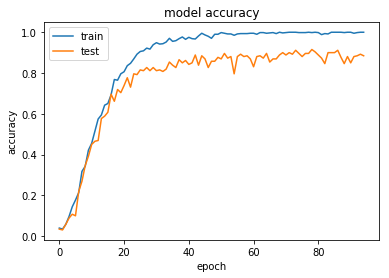

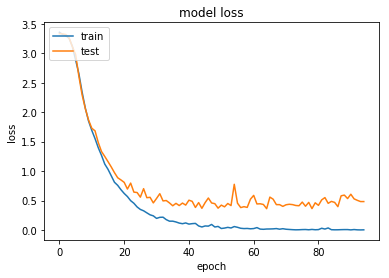

In [16]:
# summarize history for accuracy
plt.plot(TCNRaw_Hist.history['acc'])
plt.plot(TCNRaw_Hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(TCNRaw_Hist.history['loss'])
plt.plot(TCNRaw_Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()